## import libraries 

In [40]:
import pandas
import configparser
import psycopg2

In [41]:
config = configparser.ConfigParser()
config.read('config.ini')

host = config['myaws']['host']
db = config['myaws']['db']
user = config['myaws']['user']
pwd = config['myaws']['pwd']

In [42]:
conn = psycopg2.connect(host = host,
                       user = user,
                        password = pwd,
                        dbname = db
                       )
cur = conn.cursor()

## create the hosue table

make sure change the schema name to your gp number

In [43]:


# replace the schema and table name to your schema and table name
table_sql = """
            CREATE TABLE IF NOT EXISTS gp13.property
            (

                price integer,
                bed integer,
                bath integer,
                area integer,
                address VARCHAR(200),
                PRIMARY KEY(address)
            );

            """



use the bellow cell only if you want to delete the table

In [44]:
#conn.rollback()
#table_sql="drop table if exists demo.house"

In [45]:

cur.execute(table_sql)
conn.commit()

## define the search region

In [46]:
url = 'https://www.trulia.com/FL/Miami_Beach/33109/'

In [47]:


import urllib.request
response = urllib.request.urlopen(url)
html_data= response.read()
# print(html_data.decode('utf-8'))



In [48]:


from bs4 import BeautifulSoup
soup = BeautifulSoup(html_data,'html.parser')
# print (soup)



## insert the records into database

In [49]:

for li_class in soup.find_all('li', class_ = 'Grid__CellBox-sc-144isrp-0 SearchResultsList__WideCell-b7y9ki-2 jiZmPM'):
    try:
        for price_div in li_class.find_all('div',{'data-testid':'property-price'}):
            price =int(price_div.text.replace('$','').replace(",",""))
        for bed_div in li_class.find_all('div', {'data-testid':'property-beds'}):
            bed= int(bed_div.text.replace('bd','').replace(",",""))
        for bath_div in li_class.find_all('div',{'data-testid':'property-baths'}):
            bath =int(bath_div.text.replace('ba','').replace(",",""))
        for area_div in li_class.find_all('div',{'data-testid':'property-floorSpace'}):
            area=int(area_div.text.split('sqft')[0].replace(",",""))
        for address_div in li_class.find_all('div',{'data-testid':'property-address'}):
            address =address_div.text

        try:
            sql_insert = """
                        insert into gp13.property(price,bed,bath,area,address)
                        values('{}','{}','{}','{}','{}')            
                        """.format(price,bed,bath,area,address)

            cur.execute(sql_insert)
            conn.commit()
        except:
            conn.rollback()
    except:
        pass
        

## Query the Table

In [50]:
df = pandas.read_sql_query('select * from gp13.property ', conn)
df[:10]

,price,bed,bath,area,address
0,234900,3,2,1296,"1835 Cobblestone Dr, Harrisonburg, VA 22801"
1,580000,7,5,4882,"1835 Cumberland Dr, Rockingham, VA 22801"
2,11900000,5,7,2400,"5313 Fisher Island Dr #5313, Miami Beach, FL 3..."
3,18500000,7,7,7137,"6923 Valencia Dr, Miami Beach, FL 33109"
4,334900,4,3,1584,"135 Port Republic Rd, Harrisonburg, VA 22801"
5,429000,4,3,2392,"1038 James Pl, Harrisonburg, VA 22801"
6,459000,4,4,3658,"524 Paul St, Harrisonburg, VA 22801"
7,517000,4,3,3511,"492 S Mason St, Harrisonburg, VA 22801"
8,539000,4,4,3522,"3210 Barrington Dr, Rockingham, VA 22801"
9,339000,5,2,2016,"2953 Rawley Pike, Rockingham, VA 22801"


## basic stat

In [51]:
df.describe()

,price,bed,bath,area
count,1.400000e+02,140.000000,140.000000,140.000000
mean,3.507563e+06,3.607143,3.628571,2692.900000
std,6.159607e+06,2.290727,2.604210,1733.363878
min,6.500000e+04,1.000000,1.000000,596.000000
25%,3.379750e+05,3.000000,2.000000,1556.250000
50%,6.299500e+05,3.000000,3.000000,2090.000000
75%,3.999000e+06,4.000000,4.000000,3513.750000
max,4.800000e+07,15.000000,16.000000,10194.000000


## price distribution

<AxesSubplot:>

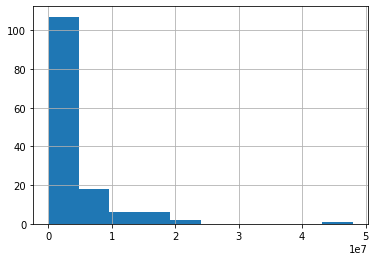

In [52]:
df['price'].hist()

## bed vs bath

<AxesSubplot:xlabel='bed', ylabel='bath'>

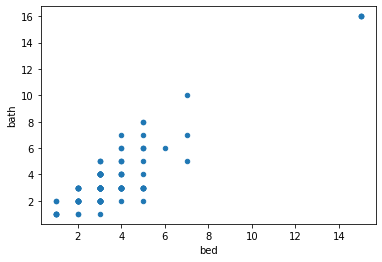

In [53]:
df.plot.scatter(x='bed',y='bath')